In [10]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

## Cargamos los datos

In [3]:
# Datos de conexión de Supabase
host = "aws-0-us-east-1.pooler.supabase.com"
user = "postgres.bfpvgfrvcwmresxlsium"
password = "jExls2hLZ0Wvyjbt"
dbname = "postgres"

# Conectar a la base de datos PostgreSQL en Supabase
conn = psycopg2.connect(
    host=host,
    user=user,
    password=password,
    dbname=dbname
)
cursor = conn.cursor()

print("Conectado a Supabase.")

Conectado a Supabase.


In [4]:
query = "SELECT * FROM hospital1_data"
data1 = pd.read_sql_query(query, conn)

query = "SELECT * FROM hospital2_data"
data2 = pd.read_sql_query(query, conn)

C:\Users\javip\AppData\Local\Temp\ipykernel_26828\3283834440.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data1 = pd.read_sql_query(query, conn)
C:\Users\javip\AppData\Local\Temp\ipykernel_26828\3283834440.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data2 = pd.read_sql_query(query, conn)


## Inspección inicial

In [5]:
print("Data1 shape:", data1.shape)
print("Data2 shape:", data2.shape)

Data1 shape: (14712, 54)
Data2 shape: (12737, 54)


In [6]:
data1.columns.values

array(['patient__id', 'patient__id1', 'nationality', 'age',
       'gender__k_female__e_male', 'date_of_first_symptoms',
       'basvurutarihi', 'fever_temperature', 'oxygen_saturation',
       'history_of_fever', 'cough', 'sore_throat', 'runny_nose',
       'wheezing', 'shortness_of_breath', 'lower_chest_wall_indrawing',
       'chest_pain', 'conjunctivitis', 'lymphadenopathy', 'headache',
       'loss_of_smell', 'loss_of_taste', 'fatigue_malaise', 'anorexia',
       'altered_consciousness_confusion', 'muscle_aches', 'joint_pain',
       'inability_to_walk', 'abdominal_pain', 'diarrhoea',
       'vomiting_nausea', 'skin_rash', 'bleeding', 'other_symptoms',
       'chronic_cardiac_disease', 'hypertension',
       'chronic_pulmonary_disease', 'asthma', 'chronic_kidney_disease',
       'obesity', 'liver_disease', 'asplenia',
       'chronic_neurological_disorder', 'malignant_neoplasm',
       'chronic_hematologic_disease', 'aids_hiv',
       'diabetes_mellitus_type_1', 'diabetes_mellitus

In [7]:
data2.columns.values

array(['patient_id', 'admission_id', 'country_of_residence', 'age', 'sex',
       'date_of_first_symptoms', 'admission_date', 'fever_temperature',
       'oxygen_saturation', 'history_of_fever', 'cough', 'sore_throat',
       'runny_nose', 'wheezing', 'shortness_of_breath',
       'lower_chest_wall_indrawing', 'chest_pain', 'conjunctivitis',
       'lymphadenopathy', 'headache', 'loss_of_smell', 'loss_of_taste',
       'fatigue_malaise', 'anorexia', 'altered_consciousness_confusion',
       'muscle_aches', 'joint_pain', 'inability_to_walk',
       'abdominal_pain', 'diarrhoea', 'vomiting_nausea', 'skin_rash',
       'bleeding', 'other_symptoms', 'chronic_cardiac_disease',
       'hypertension', 'chronic_pulmonary_disease', 'asthma',
       'chronic_kidney_disease', 'obesity', 'liver_disease', 'asplenia',
       'chronic_neurological_disorder', 'malignant_neoplasm',
       'chronic_hematologic_disease', 'aids_hiv',
       'diabetes_mellitus_type_1', 'diabetes_mellitus_type_2',
       'r

Observamos que ambos datasets tienen "casi" las mismas features, exceptuando algunas de las que desconocemos su significado (basvurutarihi), y otras, que tienen nombres diferentes en los dos conjuntos pero probablemente se correspondan con la misma característica (nationality | country of residence).

#### 1. Vamos a ver la calidad de los datos

In [161]:
data1.isna().sum()[data1.isna().sum() > 0]

fever_temperature                 468
oxygen_saturation                   4
chronic_kidney_disease              7
obesity                            22
liver_disease                       6
asplenia                           22
chronic_neurological_disorder       2
chronic_hematologic_disease         2
aids_hiv                            2
diabetes_mellitus_type_1            3
diabetes_mellitus_type_2            2
rheumatologic_disorder              2
dementia                            2
pcr_result                       1176
dtype: int64

In [162]:
data2.isna().sum()[data2.isna().sum() > 0]

country_of_residence                  3
age                                   3
sex                                   3
date_of_first_symptoms                3
admission_date                        3
fever_temperature                  1222
oxygen_saturation                     7
history_of_fever                      8
cough                                 1
sore_throat                           1
runny_nose                            3
wheezing                              3
shortness_of_breath                   3
lower_chest_wall_indrawing            3
chest_pain                            3
conjunctivitis                        3
lymphadenopathy                       3
headache                              1
loss_of_smell                         1
loss_of_taste                         1
fatigue_malaise                       1
anorexia                              1
altered_consciousness_confusion       1
muscle_aches                          1
joint_pain                            1


Observamos que existe una alta cantidad de valores nulos, especialmente en el segundo dataset. Habrá que ver como se tratan.

In [163]:
print(data1.duplicated().sum())
print(data2.duplicated().sum())

0
1


El segundo dataset tiene una fila duplicada:

In [164]:
data2[data2.duplicated()]

,patient_id,admission_id,country_of_residence,age,sex,date_of_first_symptoms,admission_date,fever_temperature,oxygen_saturation,history_of_fever,cough,sore_throat,runny_nose,wheezing,shortness_of_breath,lower_chest_wall_indrawing,chest_pain,conjunctivitis,lymphadenopathy,headache,loss_of_smell,loss_of_taste,fatigue_malaise,anorexia,altered_consciousness_confusion,muscle_aches,joint_pain,inability_to_walk,abdominal_pain,diarrhoea,vomiting_nausea,skin_rash,bleeding,other_symptoms,chronic_cardiac_disease,hypertension,chronic_pulmonary_disease,asthma,chronic_kidney_disease,obesity,liver_disease,asplenia,chronic_neurological_disorder,malignant_neoplasm,chronic_hematologic_disease,aids_hiv,diabetes_mellitus_type_1,diabetes_mellitus_type_2,rheumatologic_disorder,dementia,tuberculosis,smoking,other_risks,pcr_result
12704,-1,-1,None,NaN,None,None,None,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive


Parecen dos filas donde todos los valores o la gran mayoría son nulos.

#### 2. Análisis de la variable objetivo

In [8]:
print(data1["pcr_result"].value_counts())
print("---")
print(data2["pcr_result"].value_counts())

pcr_result
positive    12434
negative     1102
Name: count, dtype: int64
---
pcr_result
positive    9778
negative    2925
Name: count, dtype: int64


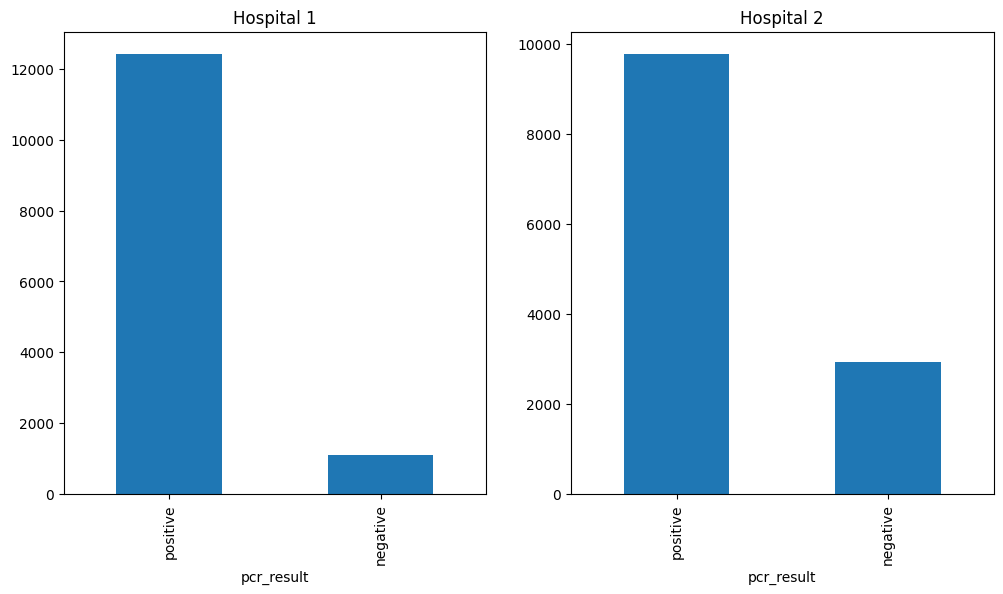

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
data1["pcr_result"].value_counts().plot(kind="bar", ax=ax[0])
data2["pcr_result"].value_counts().plot(kind="bar", ax=ax[1])
ax[0].set_title("Hospital 1")
ax[1].set_title("Hospital 2")
plt.show()

Observamos que la clase 'negative' está bastante desbalanceada, especialmente en el primer dataset, donde solo se corresponde con el 8.8% de los datos. Esto posiblemente será un problema que afecte a la predicción de los modelos. Deberemos tratarlo con cuidado.

#### 3. Tipos de las variables y gráficas básicas

In [166]:
data1.dtypes

patient__id                          int64
patient__id1                         int64
nationality                         object
age                                  int64
gender__k_female__e_male            object
date_of_first_symptoms              object
basvurutarihi                       object
fever_temperature                  float64
oxygen_saturation                  float64
history_of_fever                     int64
cough                                int64
sore_throat                          int64
runny_nose                           int64
wheezing                             int64
shortness_of_breath                  int64
lower_chest_wall_indrawing           int64
chest_pain                           int64
conjunctivitis                       int64
lymphadenopathy                      int64
headache                             int64
loss_of_smell                        int64
loss_of_taste                        int64
fatigue_malaise                      int64
anorexia   

Observamos que muchos de ellos son de tipo 'int64' y 'float64', aunque la gran mayoría (síntomas, enfermedades crónicas, riesgos) son variables categóricas, concretamente booleanas (0/1). Observamos una variable interesante: date_of_first_symptoms, que se ha leído como tipo 'object', aunque la transformaremos a fecha. Nos puede ayudar a visualizar cómo se han distribuido los positivos y negativos a lo largo del tiempo. 

Antes de ello, visualizaremos unos histogramas con variables relevantes: age, fever_temperature y oxygen_saturation, las únicas variables numéricas de ambos datasets.

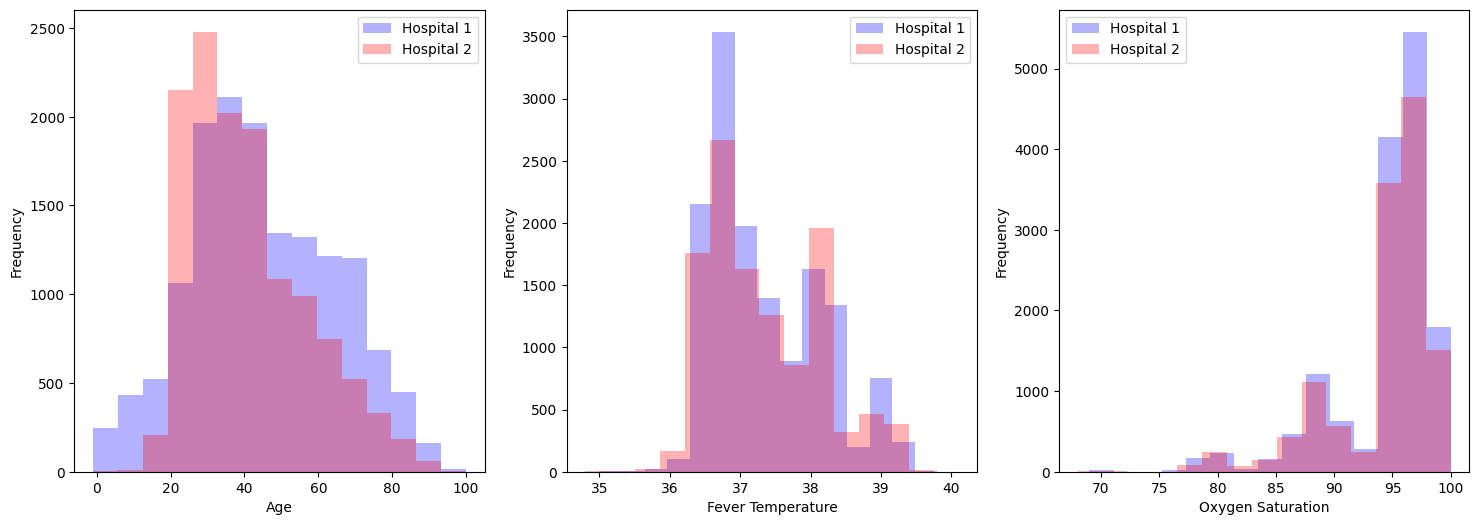

Media data1['age']: 44.969412724306686
Media data2['age']: 40.784199780116225
---
Media data1['fever_temperature']: 37.34355518112889
Media data2['fever_temperature']: 37.341684759009986
---
Media data1['oxygen_saturation']: 93.66759586619527
Media data2['oxygen_saturation']: 93.57690494893951


In [ ]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
data1["age"].plot(kind="hist", bins=15, alpha=0.3, color="blue", label="Hospital 1")
data2["age"].plot(kind="hist", bins=15, alpha=0.3, color="red", label="Hospital 2")
plt.xlabel("Age")
plt.legend()

plt.subplot(1, 3, 2)
data1["fever_temperature"].plot(kind="hist", bins=15, alpha=0.3, color="blue", label="Hospital 1")
data2["fever_temperature"].plot(kind="hist", bins=15, alpha=0.3, color="red", label="Hospital 2")
plt.xlabel("Fever Temperature")
plt.legend()

plt.subplot(1, 3, 3)
ox_sat_1 = data1[data1["oxygen_saturation"] > 40]['oxygen_saturation']
ox_sat_2 = data2[data2["oxygen_saturation"] > 40]['oxygen_saturation']
ox_sat_1.plot(kind="hist", bins=15, alpha=0.3, color="blue", label="Hospital 1")
ox_sat_2.plot(kind="hist", bins=15, alpha=0.3, color="red", label="Hospital 2")
plt.xlabel("Oxygen Saturation")
plt.legend()

plt.show()

print("Media data1['age']:", data1['age'].mean())
print("Media data2['age']:", data2['age'].mean())
print("---")
print("Media data1['fever_temperature']:", data1['fever_temperature'].mean())
print("Media data2['fever_temperature']:", data2['fever_temperature'].mean())
print("---")
print("Media data1['oxygen_saturation']:", data1['oxygen_saturation'].mean())
print("Media data2['oxygen_saturation']:", data2['oxygen_saturation'].mean())

Parece que la edad sigue una distribución cercana a la normal en ambos datasets, con medias cercanas a 40-45 años, aunque la edad más frecuente se sitúa entre los 25-30. En cuanto a la temperatura, como era esperable, se sitúa en un rango de 36 a 39, siendo más frecuente la temperatura de 37ºC, como es lógico. Finalmente, sobre la saturación de oxígeno en sangre, hemos observado que existen valores atípicos en ambos datasets (los veremos ahora en los boxplots), por lo que hemos filtrado estas variables. Después del filtrado, vemos que las variables se mueven en un rango relativamente grande, desde 75 a 100. Los valores más comunes se sitúan al final, cercanos a 95-98. Sin embargo, existen muchos casos entre 75-90, lo cual implica que los pacientes están en una situación grave.

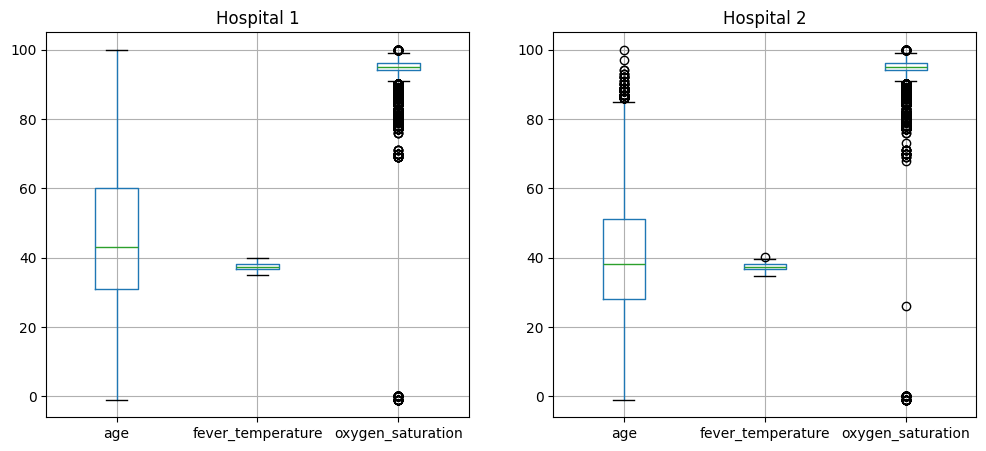

In [168]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
data1[["age", "fever_temperature", "oxygen_saturation"]].boxplot()
plt.title("Hospital 1")

plt.subplot(1, 2, 2)
data2[["age", "fever_temperature", "oxygen_saturation"]].boxplot()
plt.title("Hospital 2")

plt.show()

Los dos datasets presentan un comportamiento similiar, especialmente en fever_temperature y en oxygen_saturation. En cuanto a la edad, a pesar de que la mediana se encuentre cercana a 40 en ambos casos, en el segundo dataset hay menos muestras cercanas a los 100 años, y por ello las que hay se consideran atípicos. También existen atípicos de 'oxygen_saturation' en ambos datasets, concretamente en -1. Los consideraremos nulos. Finalmente, existe un dato de oxygen_saturation en 25-30, lo cual es imposible. Habrá que valorarlo.

Además, es fácilmente observable que las variables numéricas se mueven en rangos considerablemente diferentes, por lo que habrá que aplicar técnicas de normalización.

De forma rápida, veremos también la distribución de todas estas variables binarias que hemos mencionado antes.

In [169]:
pd.set_option("display.max_columns", None)

In [170]:
data1.loc[:, "cough":"other_risks"].apply(lambda x: x.value_counts())

,cough,sore_throat,runny_nose,wheezing,shortness_of_breath,lower_chest_wall_indrawing,chest_pain,conjunctivitis,lymphadenopathy,headache,loss_of_smell,loss_of_taste,fatigue_malaise,anorexia,altered_consciousness_confusion,muscle_aches,joint_pain,inability_to_walk,abdominal_pain,diarrhoea,vomiting_nausea,skin_rash,bleeding,other_symptoms,chronic_cardiac_disease,hypertension,chronic_pulmonary_disease,asthma,chronic_kidney_disease,obesity,liver_disease,asplenia,chronic_neurological_disorder,malignant_neoplasm,chronic_hematologic_disease,aids_hiv,diabetes_mellitus_type_1,diabetes_mellitus_type_2,rheumatologic_disorder,dementia,tuberculosis,smoking,other_risks
0,11100,11439,11709,14481,11451,14693,14507,14694,14673,11875,14682,14693,11604,14682,14686,14667,14627,14697,14473,11766,11761,14687,14690,14691,14596,11837,14669,11871,14675,14656,14643,14666,14686,14645,14683,14688,14683,14675,14681,14686,14686,14160,14692
1,3612,3273,3003,231,3261,19,205,18,39,2837,30,19,3108,30,26,45,85,15,239,2946,2951,25,22,21,116,2875,43,2841,30,34,63,24,24,67,27,22,26,35,29,24,26,552,20


Echando un vistazo rápido, vemos que domina el valor 0 (la categoría "No") en todas las variables. No obstante, en unas más que en otras.

Observamos que en variables de síntomas comunes, como 'cough', 'sore_throat' o 'runny_nose' existe una gran cantidad de 1's, indicando que son más frecuentes que los demás, como 'conjunctivitis' o 'inability_to_walk'.

#### 4. Correlación

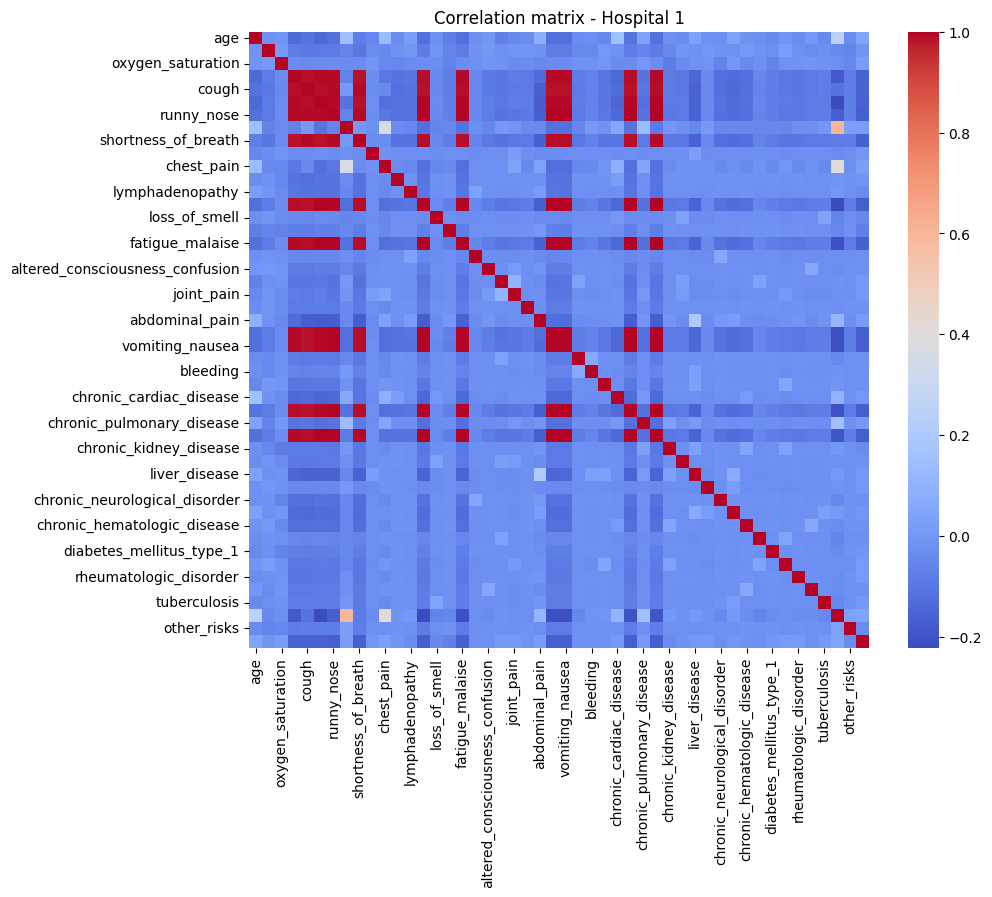

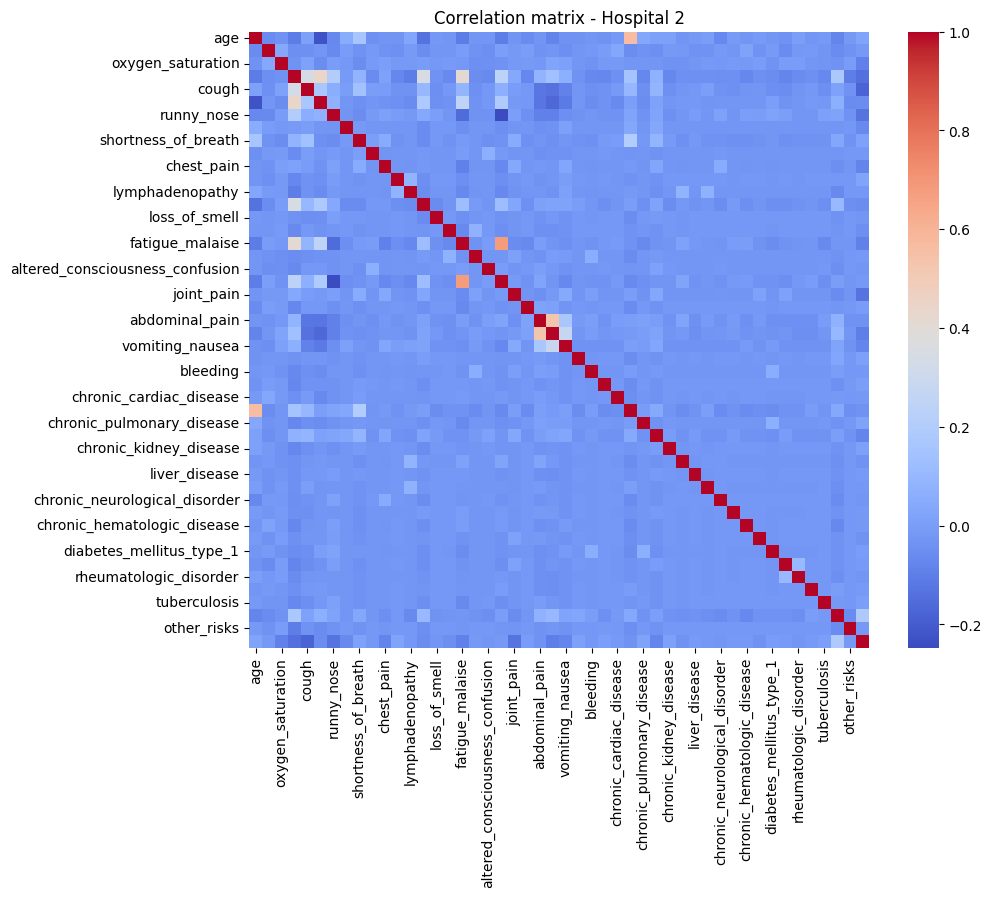

In [171]:
import seaborn as sns

# Add pcr_result column to the correlation matrix
data1["pcr_result"] = data1["pcr_result"].map({"positive": 1, "negative": 0}).astype("Int64") 
data2["pcr_result"] = data2["pcr_result"].map({"positive": 1, "negative": 0}).astype("Int64")

# Remove patient_id columns
num_cols1 = data1.select_dtypes(include=["float64", "int64"]).columns[2:]
num_cols2 = data2.select_dtypes(include=["float64", "int64"]).columns[2:]

corr1 = data1[num_cols1].corr()
corr2 = data2[num_cols2].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr1.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation matrix - Hospital 1")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(corr2.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation matrix - Hospital 2")
plt.show()

Mientras que en la primera matriz de correlación se observan correlaciones interesantes, en la segunda es más complejo ver este tipo de asociaciones.

Veamos cuáles son las más altas:

In [172]:
corr1 = corr1.mask(corr1 == 1, 0) # mask the diagonal
corr2 = corr2.mask(corr2 == 1, 0) # mask the diagonal

corr1 = corr1.abs().unstack().sort_values(ascending=False).drop_duplicates()
corr1 = corr1[corr1 != 1]
print(corr1.head(5))

print("------")

corr2 = corr2.abs().unstack().sort_values(ascending=False).drop_duplicates()
corr2 = corr2[corr2 != 1]
print(corr2.head(5))

headache         asthma             0.939769
                 hypertension       0.939205
asthma           hypertension       0.933151
vomiting_nausea  diarrhoea          0.929377
headache         vomiting_nausea    0.924147
dtype: float64
------
muscle_aches      fatigue_malaise    0.398702
hypertension      age                0.330920
diarrhoea         abdominal_pain     0.293633
history_of_fever  sore_throat        0.246917
                  fatigue_malaise    0.244616
dtype: float64


#### 5. Evolución temporal

In [173]:
data1["date_of_first_symptoms"] = pd.to_datetime(data1["date_of_first_symptoms"])
data2["date_of_first_symptoms"] = pd.to_datetime(data2["date_of_first_symptoms"])

In [174]:
print("Hospital 1")
print("First date:", data1["date_of_first_symptoms"].min())
print("Last date:", data1["date_of_first_symptoms"].max())

print("---")

print("Hospital 2")
print("First date:", data2["date_of_first_symptoms"].min())
print("Last date:", data2["date_of_first_symptoms"].max())

Hospital 1
First date: 2021-05-01 00:00:00
Last date: 2022-03-14 00:00:00
---
Hospital 2
First date: 2021-03-01 00:00:00
Last date: 2022-03-13 17:23:00


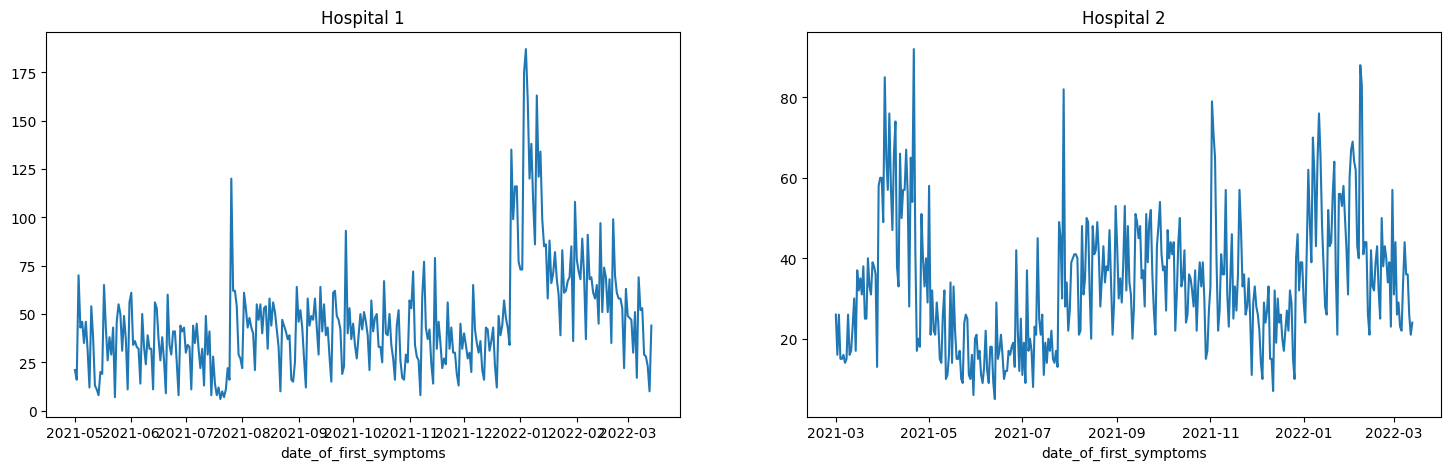

In [175]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
data1["date_of_first_symptoms"].dt.date.value_counts().sort_index().plot()
plt.title("Hospital 1")

plt.subplot(1, 2, 2)
data2["date_of_first_symptoms"].dt.date.value_counts().sort_index().plot()
plt.title("Hospital 2")

plt.show()

Vemos diferentes patrones temporales (aunque con cierta y parecida estacionalidad) en ambos datasets. No obstante, ambos tienen un gran pico alrededor de enero de 2022.

Podemos agruparlo por semanas, para verlo más claro.

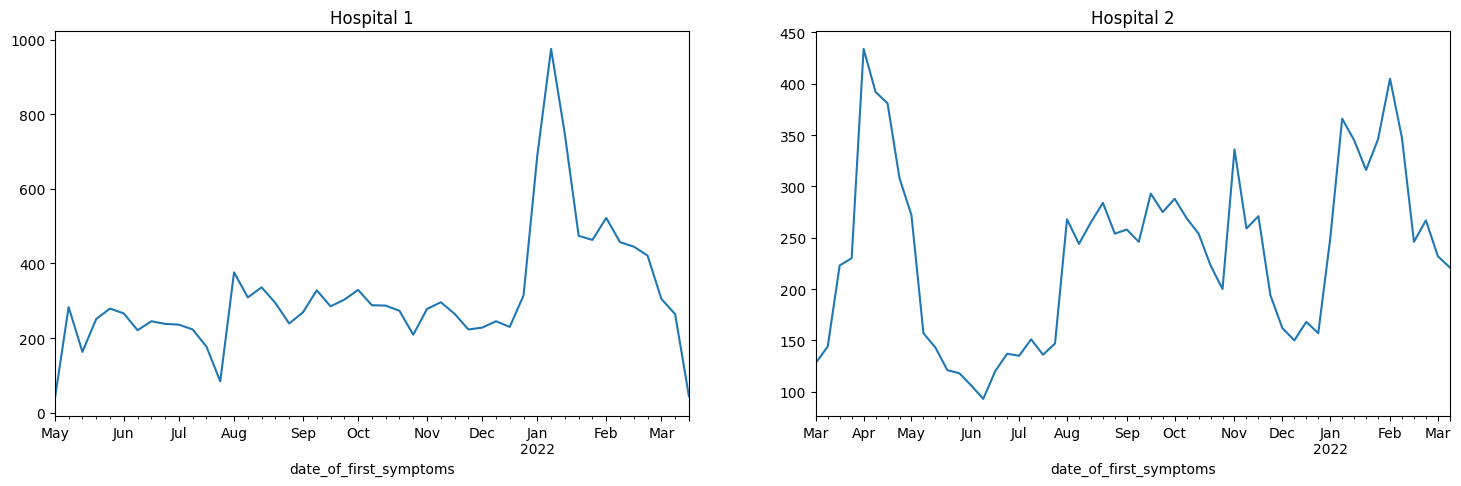

In [176]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
data1["date_of_first_symptoms"].dt.to_period("W").value_counts().sort_index().plot()
plt.title("Hospital 1")

plt.subplot(1, 2, 2)
data2["date_of_first_symptoms"].dt.to_period("W").value_counts().sort_index().plot()
plt.title("Hospital 2")

plt.show()

Además, podemos ver también el número de positivos.

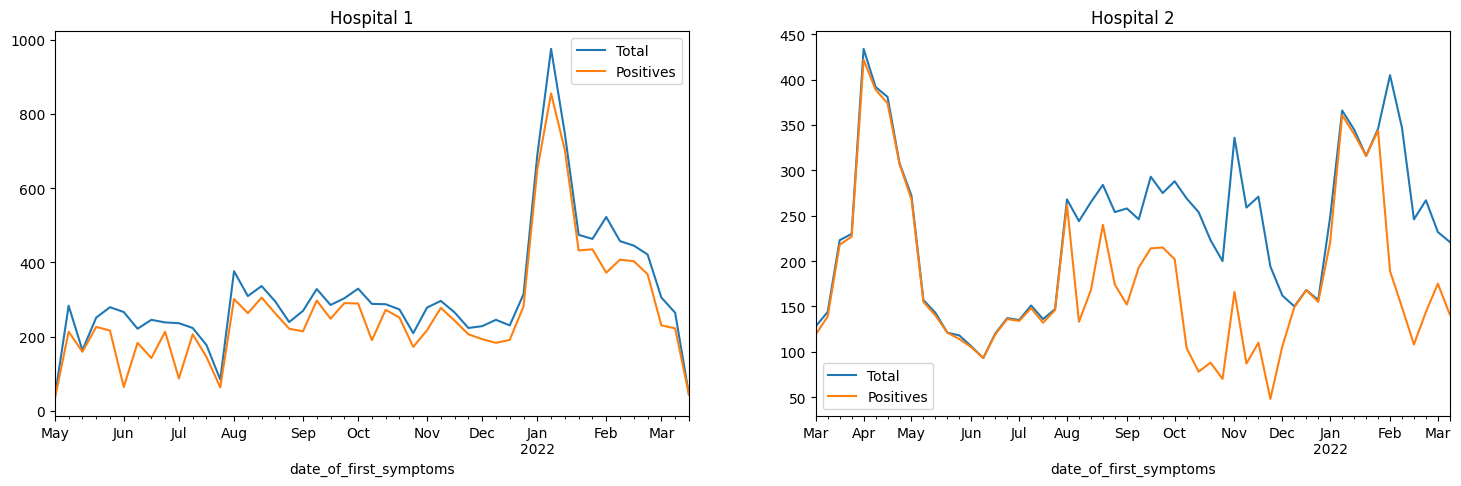

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
data1["date_of_first_symptoms"].dt.to_period("W").value_counts().sort_index().plot(label="Total")
data1.groupby(data1["date_of_first_symptoms"].dt.to_period("W"))["pcr_result"].sum().plot(label="Positives")
plt.title("Hospital 1")
plt.legend()

plt.subplot(1, 2, 2)
data2["date_of_first_symptoms"].dt.to_period("W").value_counts().sort_index().plot(label="Total")
data2.groupby(data2["date_of_first_symptoms"].dt.to_period("W"))["pcr_result"].sum().plot(label="Positives")
plt.title("Hospital 2")
plt.legend()

plt.show()

Observamos que la tendencia de positivos ha acompañado a la tendencia de pruebas PCR realizadas, siendo un gran porcentaje del total excepto ciertos meses en el hospital 2.